In [1]:
from utils import *
from prepare_ds import *
from train_ml import *
from create_map import *
from validation import *
from visualisation import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from osgeo.gdal import GDT_UInt32

init()

Initialization paths...
All paths was initialized.
Initialization paths...
All paths was initialized.


In [2]:
sentinel = "/Users/stephenhawking/Coding/ML/low2high_map/data/input/images_10m/Sentinel_Samara/reg_64_2020_06_90d_comp.b.tif"
sentinel = load_tif(sentinel, only_first=True)
modis = "/Users/stephenhawking/Coding/ML/low2high_map/data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif"
modis = load_tif(modis, only_first=True)

modis_arr = modis["array"]
sentinel_arr = sentinel["array"]

Loading file: /Users/stephenhawking/Coding/ML/low2high_map/data/input/images_10m/Sentinel_Samara/reg_64_2020_06_90d_comp.b.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.


In [ ]:
print("sentinel transform: ", sentinel["transform"])
print("modis: ", modis["transform"])

diff_0 = (
    round(sentinel["array"].shape[0] / 23, 2),
    round(sentinel["array"].shape[1] / 23, 2),
)
diff_10 = (
    round((sentinel["array"].shape[0] - 10) / 23, 2),
    round((sentinel["array"].shape[1] - 10) / 23, 2),
)

print(f"Sentinel / 23m: {diff_0}\n-10px:    {diff_10}")
print(f"Modis:    {modis['array'].shape}")


sentinel transform:  (293390.0, 10.0, 0.0, 6060930.0, 0.0, -10.0)
modis:  (293390.0, 230.0, 0.0, 6060930.0, 0.0, -230.0)
Sentinel / 23m: (1420.17, 1348.43)
-10px:    (1419.74, 1348.0)
Modis:    (1420, 1348)


In [3]:
A = np.arange(modis["array"].size, dtype=np.uint32)
A = A.reshape(modis_arr.shape)

print(modis_arr.size, modis_arr.size == A.size)
print(A.dtype, modis_arr.dtype, sentinel_arr.dtype)
A

1914160 True
uint32 uint8 uint16


array([[      0,       1,       2, ...,    1345,    1346,    1347],
       [   1348,    1349,    1350, ...,    2693,    2694,    2695],
       [   2696,    2697,    2698, ...,    4041,    4042,    4043],
       ...,
       [1910116, 1910117, 1910118, ..., 1911461, 1911462, 1911463],
       [1911464, 1911465, 1911466, ..., 1912809, 1912810, 1912811],
       [1912812, 1912813, 1912814, ..., 1914157, 1914158, 1914159]],
      dtype=uint32)

In [4]:
modis["array"] = A
out = DEFAULT_PATH["cropped_labels"] + "px_to_idx_" + os.path.basename(modis["path"])
out2 = DEFAULT_PATH["cropped_labels"] + "grid_sentinel_to_modis.tif"

save_tif(modis, out, dtype=GDT_UInt32)
cut_tif_by(out, sentinel, out2, resize=10, mode="nearest", aligned=True, verbose=True)

Data saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/px_to_idx_landcover23c_v571_2020.Samara.tif
Map cutted and saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/grid_sentinel_to_modis.tif


In [21]:
out2 = DEFAULT_PATH["cropped_labels"] + "grid_sentinel_to_modis.tif"
sentinel_id = load_tif(out2, only_first=True)
ids = sentinel_id["array"]

Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/grid_sentinel_to_modis.tif
Files was loaded.


In [40]:
sentinel_shape = ids.shape
# modis_shape = modis_arr.shape
# H = modis_shape[0]
# W = modis_shape[1]

ids = ids.reshape(-1)
sentinel_arr = sentinel_arr.reshape(-1).astype(np.float64)
count = np.bincount(ids)
print(count)

sum = np.bincount(ids, weights=sentinel_arr)
print(sum, sum.shape)

sum_square = np.bincount(ids, weights=sentinel_arr**2)
print(sum_square, sum_square.shape)

std = np.zeros_like(sum_square, dtype=np.float64)
std = sum_square / count - (sum / count) ** 2
print(std, std.shape)
std = np.sqrt(std)

[451185    529    529 ...    529    529    529]
[452470.      0.      0. ...      0.      0.      0.] (1914160,)
[2.44987492e+08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00] (1914160,)
[541.98107947   0.           0.         ...   0.           0.
   0.        ] (1914160,)


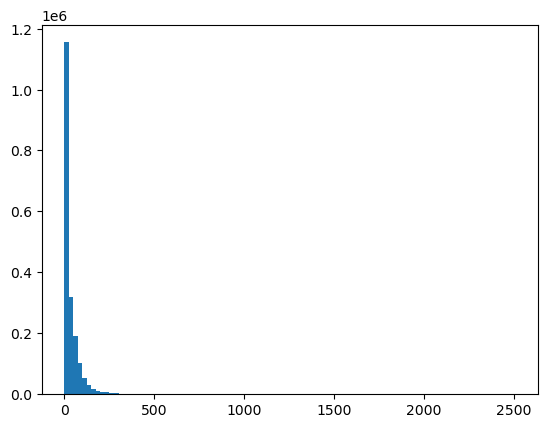

array([23.2804871,  0.       ,  0.       , ...,  0.       ,  0.       ,
        0.       ])

In [47]:
std = np.sqrt(std)
plt.hist(std, bins=100)
plt.show()
std

In [53]:
modis["array"] = std.reshape(modis["array"].shape)
out2 = DEFAULT_PATH["cropped_labels"] + "std_sentinel_to_modis.tif"

save_tif(modis, out2, dtype=GDT_UInt32)


Data saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/std_sentinel_to_modis.tif


In [ ]:
std.reshape(modis["array"])

ValueError: maximum supported dimension for an ndarray is 32, found 1420

In [ ]:

std = sum_square / count - (sum / count) ** 2
print("std before sqrt: ", std.mean())
print("sumsq: ", (sum_square / count).mean())
print("sum: ", (sum / count).mean())
print("sum^2: ", ((sum / count) ** 2).mean())